# VIT 

This notebook is for traning a Vision Transformer model for dog emotion detection

#### REF
[VIT TIMM](https://huggingface.co/timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)<br>
[Pytorch](https://pytorch.org/docs/stable/index.html)<br>
[Grad-CAM](https://github.com/jacobgil/pytorch-grad-cam/blob/master/usage_examples/vit_example.py#L55)


## Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import timm
import matplotlib.pyplot as plt
import sys
from pytorch_grad_cam import GradCAM
sys.path.insert(1, '/mnt/c/Eclipse/IU Spring 2025/is_the_dog_happy')

from get_data_loaders import *

/home/eclipse/anaconda3/envs/DOG_EMOTION/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/eclipse/anaconda3/envs/DOG_EMOTION/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/eclipse/anaconda3/envs/DOG_EMOTION/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Visulization Functions

In [3]:
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

unnormalize = transforms.Normalize(
    mean=[-m/s for (m,s) in zip(MEAN, STD)],
    std =[1.0/s for s in STD]
)

In [4]:
def vis_samples(loader, rows=3, cols=3, show_mask=False, alpha=.35):
    fig = plt.figure(figsize=(cols*3, rows*3))

    for i in range(1, rows*cols+1):
        idx = torch.randint(len(loader.dataset), (1,)).item()
        img, label = loader.dataset[idx]

        # split channels
        if img.shape[0] == 4:
            rgb, mask = img[:3], img[3:]
        else:
            rgb, mask = img, None

        rgb = unnormalize(rgb.clone())
        rgb_np = rgb.permute(1,2,0).numpy().clip(0,1)

        ax = fig.add_subplot(rows, cols, i)
        ax.axis("off")
        ax.set_title(loader.dataset.classes[label])

        ax.imshow(rgb_np)

        if show_mask and mask is not None:
            m = mask.squeeze().numpy()
            ax.imshow(m, cmap="Reds", alpha=alpha)

    plt.tight_layout(); plt.show()


## Model

In [5]:
def train_model(model, train_loader, vali_loader):
    creterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    num_epochs = 10

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = creterion(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch: {epoch}, Loss: {avg_loss}")

        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in vali_loader:
                data, target = data.to(device), target.to(device)

                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

            val_accuracy = 100 * correct / total
            print(f"Validation accuracy: {val_accuracy}")

    torch.save(model.state_dict(), "vit_model.pth")

## Experiment 1: Whole Image

### Data Processing

In [6]:
train_loader, vali_loader, test_loader, num_classes = get_loaders("../data")

In [7]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

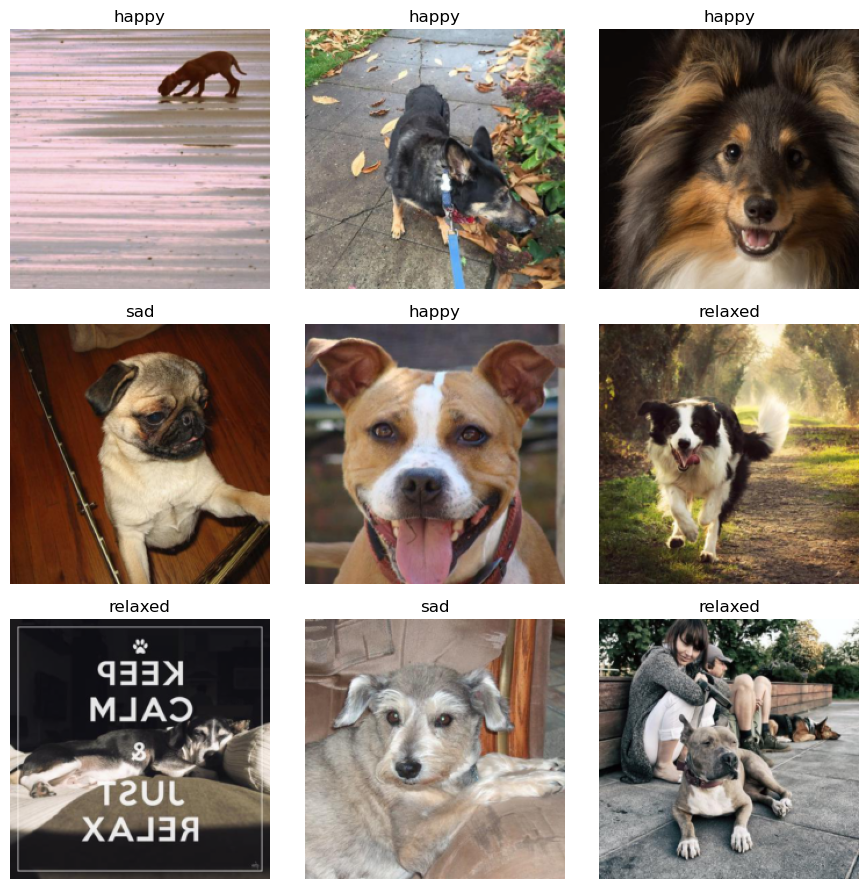

In [8]:
vis_samples(train_loader, rows=3, cols=3)

### Model Traning

In [ ]:
train_model(model, train_loader, vali_loader)

## Experiment 2: Face Annotated Image

### Data Pre-processing

In [6]:
train_loader_f_anno, vali_loader_f_anno, test_loader_f_anno, num_classes_f_anno = get_loaders("../data", "../annotations_face")

[TOO FEW POINTS] ../annotations_face/train/angry/108546979_4f9d9027da_b.txt – found 0 values, need 4, skipping
[TOO FEW POINTS] ../annotations_face/train/angry/1117094770_06bfef2e1b_b.txt – found 0 values, need 4, skipping
[TOO FEW POINTS] ../annotations_face/train/angry/11355642185_1f20878def_b.txt – found 0 values, need 4, skipping
[TOO FEW POINTS] ../annotations_face/train/angry/11755637014_9276d6b152_b.txt – found 0 values, need 4, skipping
[TOO FEW POINTS] ../annotations_face/train/angry/1221584616_5b161bdee6_b.txt – found 0 values, need 4, skipping
[TOO FEW POINTS] ../annotations_face/train/angry/12580049984_95dbed9108_b.txt – found 0 values, need 4, skipping
[TOO FEW POINTS] ../annotations_face/train/angry/12983203414_98d81df780_b.txt – found 0 values, need 4, skipping
[TOO FEW POINTS] ../annotations_face/train/angry/1394076163_82f57c279a_b.txt – found 0 values, need 4, skipping
[TOO FEW POINTS] ../annotations_face/train/angry/14269444564_f0e763d3ac_b.txt – found 0 values, need 

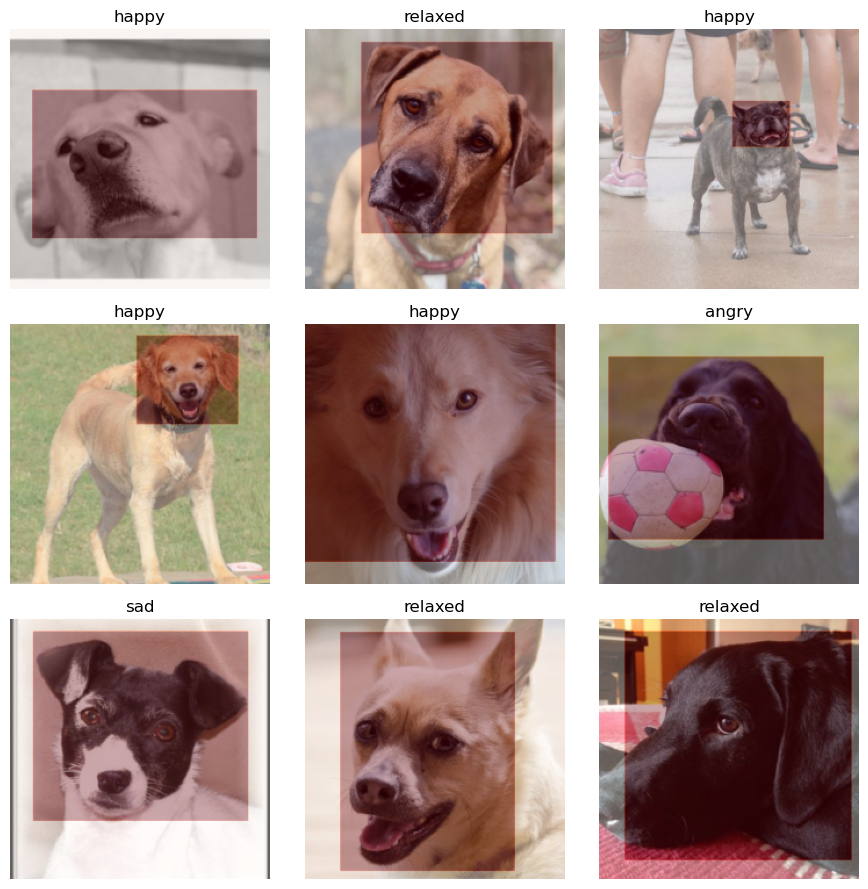

In [18]:
vis_samples(train_loader_f_anno, rows=3, cols=3, show_mask=True)

In [8]:
model_f_anno = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes_f_anno)
in_ch = model_f_anno.patch_embed.proj.in_channels 

model_f_anno.patch_embed.proj = torch.nn.Conv2d(
    4, model_f_anno.patch_embed.proj.out_channels,
    kernel_size=16, stride=16
)

model_f_anno.head = torch.nn.Linear(model_f_anno.head.in_features, 4)
model_f_anno = model_f_anno.to(device)

In [9]:
train_model(model_f_anno, train_loader_f_anno, vali_loader_f_anno)

Epoch: 0, Loss: 1.3844492769849321
Validation accuracy: 36.8474923234391
Epoch: 1, Loss: 1.3404052613645738
Validation accuracy: 34.629819174343226
Epoch: 2, Loss: 1.3044486114236176
Validation accuracy: 43.32992152848857
Epoch: 3, Loss: 1.2745479917482818
Validation accuracy: 44.83111566018424
Epoch: 4, Loss: 1.2360363915318349
Validation accuracy: 45.411122483793925
Epoch: 5, Loss: 1.2166601441162748
Validation accuracy: 44.38758103036506
Epoch: 6, Loss: 1.1972906837046473
Validation accuracy: 45.6158307744797
Epoch: 7, Loss: 1.1768652418923509
Validation accuracy: 44.933469805527125
Epoch: 8, Loss: 1.1477054825463147
Validation accuracy: 45.104060047765266
Epoch: 9, Loss: 1.120295054599887
Validation accuracy: 45.34288638689867
